In [1]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
import tensorflow.keras.regularizers as reg
import keras_tuner as kt
import numpy as np

import kaggle_functions as kaggle
import importlib
importlib.reload(kaggle);

model_number = 'model7'

In [2]:
# Create datasets
train_dataset, valid_dataset, valid_labels = kaggle.load_train_as_dataset()

batch_size = 32
train_dataset_augmented, epoch_length = kaggle.augment_dataset(train_dataset, batch_size)

### VGG-style CNN (custom)

In [3]:
class VGG(kt.HyperModel):
    def conv_layer(self, input, filters, stride=1, kernel=3, l2_reg=0.0001, padding='same'):
        return layers.Conv2D(
            filters, kernel_size=(kernel,kernel), strides=(stride,stride), 
            padding=padding, activation='relu',
            kernel_regularizer=reg.l2(l2_reg), bias_regularizer=reg.l2(l2_reg),
            kernel_initializer='he_uniform')(input)

    def build(self, hyperparameters):
        # Tunable hyperparameters
        if hyperparameters is not None:
            dense_l2_reg = hyperparameters.Float('dense_l2_reg', 0.0001, 0.01, sampling='log')
            dense_dropout = hyperparameters.Float('dense_dropout', 0.2, 0.6, step=0.2)
        else:
            dense_l2_reg = 0.001
            dense_dropout = 0.3

        # Fixed hyperparameters
        learning_rate = 0.0005

        input_layer = layers.Input(shape=(96, 96, 1))

        output = self.conv_layer(input_layer, 32, stride=2)
        output = layers.BatchNormalization()(output)
        output = self.conv_layer(output, 32)
        output = layers.BatchNormalization()(output)
        output = self.conv_layer(output, 64, stride=2)
        output = layers.BatchNormalization()(output)
        output = self.conv_layer(output, 64)
        output = layers.BatchNormalization()(output)
        output = self.conv_layer(output, 128, stride=2)
        output = layers.BatchNormalization()(output)
        output = self.conv_layer(output, 128)
        output = layers.BatchNormalization()(output)
        output = self.conv_layer(output, 256, stride=2)
        output = layers.BatchNormalization()(output)
        output = self.conv_layer(output, 256)
        output = layers.Dropout(dense_dropout / 8)(output)
        output = layers.BatchNormalization()(output)
        output = self.conv_layer(output, 512, stride=2)
        output = layers.Dropout(dense_dropout / 4)(output)
        output = layers.BatchNormalization()(output)
        output = self.conv_layer(output, 1024, padding='valid')
        output = layers.BatchNormalization()(output)

        # Final output
        output = layers.Flatten()(output)
        output = layers.Dropout(dense_dropout / 2)(output)
        output = layers.Dense(
            256, activation='relu', kernel_initializer='he_uniform',
            kernel_regularizer=keras.regularizers.l2(dense_l2_reg),
            bias_regularizer=keras.regularizers.l2(dense_l2_reg))(output)
        output = layers.Dropout(dense_dropout)(output) 
        output = layers.Dense(
            11, kernel_regularizer=keras.regularizers.l2(dense_l2_reg),
            bias_regularizer=keras.regularizers.l2(dense_l2_reg))(output)

        model = keras.models.Model(inputs=input_layer, outputs=output)

        # Create model
        model.compile(
            optimizer=keras.optimizers.Nadam(learning_rate),
            loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=['accuracy'])

        return model

# VGG().build(None).summary()

In [4]:
# Hyperparameter tuning
# Use RandomSearch to check Choice params, or Bayesian for Float/Ints
# Took 2h40m per trial
# 200 epochs may not be enough for perfect convergence (missing maybe 1% val accuracy)

reload_tuner = False
tuner_filepath = 'hypertuner_2021-11-29'

tuner_callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=25), # Reduce to 20 in future
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_accuracy', factor=0.1, patience=18, # Reduce to 15
        min_lr=0.00005, verbose=1)
]

tuner = kt.RandomSearch(VGG(),
    objective='val_accuracy',
    max_trials=5,
    seed=1,
    directory=f'models/{model_number}',
    project_name=tuner_filepath,
    overwrite=(not reload_tuner))

tuner.search_space_summary()

if reload_tuner:
    tuner.reload()
else:
    tuner.search(
        train_dataset_augmented, 
        validation_data=valid_dataset.batch(128).cache(),
        epochs=200, steps_per_epoch=epoch_length,
        callbacks=tuner_callbacks, verbose=1)

tuner.results_summary()

# model = tuner.get_best_models(2)[1]

Trial 5 Complete [02h 40m 23s]
val_accuracy: 0.7796467542648315

Best val_accuracy So Far: 0.7796467542648315
Total elapsed time: 12h 35m 24s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in models/model7\hypertuner_2021-11-29
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
dense_l2_reg: 0.0008433633337952192
dense_dropout: 0.4
Score: 0.7796467542648315
Trial summary
Hyperparameters:
dense_l2_reg: 0.0017611785596585996
dense_dropout: 0.6000000000000001
Score: 0.7783852219581604
Trial summary
Hyperparameters:
dense_l2_reg: 0.0002991777241598977
dense_dropout: 0.2
Score: 0.7666106224060059
Trial summary
Hyperparameters:
dense_l2_reg: 0.00018566433578077874
dense_dropout: 0.6000000000000001
Score: 0.7653490304946899
Trial summary
Hyperparameters:
dense_l2_reg: 0.0004442889681244208
dense_dropout: 0.2
Score: 0.7556770443916321


In [ ]:
# Fit model
print('Building new model')
model, history = kaggle.train_model(
    VGG().build(None), train_dataset_augmented, valid_dataset, 
    epochs=200, valid_patience=30, epoch_length=epoch_length)

INFO:tensorflow:Assets written to: models/model7/DeeperVGG_5\assets


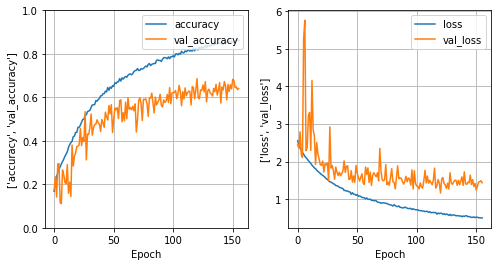

In [7]:
# Save model
model_name = 'DeeperVGG_6'
model.save(f'models/{model_number}/{model_name}')

# Plot model statistics during training
kaggle.plot_model_history(history, [['accuracy', 'val_accuracy'], ['loss', 'val_loss']])

In [ ]:
# Fine-tune model
print('Fine-tuning model')
fine_model, history = kaggle.fine_tune_model(
    tuner.get_best_models(2)[1],
    train_dataset.batch(32).cache(), valid_dataset, 
    epochs=10, learning_rate=0.00001)

In [6]:
# Save fine-tuned model
fine_model.save(f'models/{model_number}/DeeperVGG_7')

INFO:tensorflow:Assets written to: models/model7/DeeperVGG_6\assets


### Evaluate model

Accuracy: 0.8402


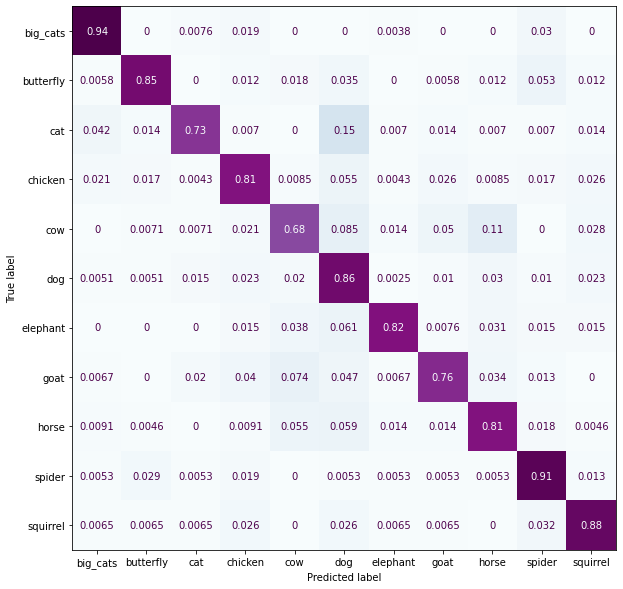

In [7]:
model_name = 'DeeperVGG_6'
model = keras.models.load_model(f'models/{model_number}/{model_name}')

test_pred_raw = model.predict(valid_dataset.batch(128))
test_pred = np.argmax(test_pred_raw, axis=1)

kaggle.print_accuracy(valid_labels, test_pred)
kaggle.plot_confusion_matrix(valid_labels, test_pred)